<a href="https://colab.research.google.com/github/nairmeghna/projects/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analsis on Amazon Reviews**

This notebook demonstrates sentiment analysis using two different techniques namely,


*   VADER - Bag of Words Approach
*   Roberta - Provided by HuggingFace

followed by a comparison between the models.


# **Read the data and NLTK basics**

**About the dataset**

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories with each review containing a textual feedback along with a 1 to 5 star rating system (1 being the least satisfied and 5 being the most satisfied). The following are the attirbutes available in the data:



1.   **ProductId (Categorical):** ID of the refenced product by the customer
2.   **UserId (Categorical) :** registered user ID

3.   **ProfileName (Text) :** registered user profile name
4.  ** HelpfulnessNumerator (Numerical) :** number of users that found the review helpful

5.   **HelpfulnessDenominator (Numerical) :** number of users who voted whether the review was helpful or not
6.   **Score (Ordinal) :** rating between 1 and 5

7.   **Time (Numerical) :** timestamp of the review
8.   **Summary (Text) :** breif summary of the review

9.   **Text (Text) :** text of the review


In [ ]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.4 MB/s eta 0:00:00


In [ ]:
# reading the data as a csv file

df = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
# checking the dimensions of the dataset

df.shape

(10000, 9)

The dataset is quite large and for this project only the first 500 rows will be taken into consideration.

In [ ]:
# reducing the dimensions of the dataset

df = df.head(500)
df.shape

(500, 9)

# **Exploratory Data Analysis on Scores**

The Score column has values between 1 to 5. Doing a value_counts() on this column would give the number of times each score appears. This can be followed by sorting using sort_index and make a bar plot of the same.

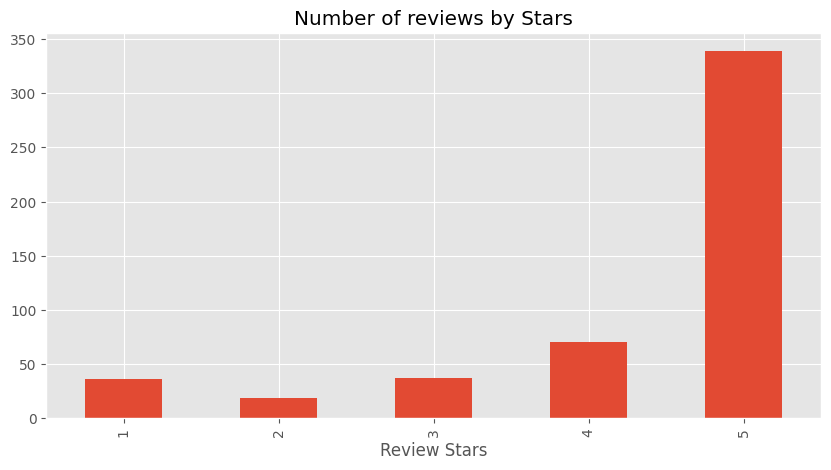

In [ ]:
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Number of reviews by Stars', figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

Here we can see that most of the reviews are 5 starred which means that the dataset is very biased towards positive reviews.

# **Basic NLTK**

We now take a random value from the Text column as an example and see what is the sentiment of that text.

In [ ]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


The sentiment of this text seems to be negative. Next, we tokenize this statement which is to basically split the statement into parts of each word including the punctuations.

In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

NLTK can be used to find the part of speach taggings on each tokens.

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

Now, we take these tagged parts of speach and put them in entities. Using the NLTK chunker, these tags can be grouped.

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# **VADER Sentiment Scoring**

We will use NLTK's SentimentInsensityAnalyzer to get the neg/neu/pos scores of the text which uses the Bag of Words approach where


*   Stop words are removed
*   Each word is scored and combined to a total score

NOTE: This approach does not account for relationships between words.





In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# creating SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

In [ ]:
# running sia on a text

sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

Here, neg = negative, neu = neutral, pos = positive. The compund score is an aggregate of neg, neu and pos ranging from -1 to +1 representing how negative or positive the text is.

In this case the scores are pretty high on negative and neutral. The compund score is going in the negatives.

In [ ]:
# running the polarity scores on the entire dataset

res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['Text']
  myid = row['ProductId']
  res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# storing the results into a pandas dataframe and merging it to original dataset

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'ProductId'})
vaders = vaders.merge(df, how = 'left')
vaders.head(3)

,ProductId,neg,neu,pos,compound,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,0.000,0.695,0.305,0.9441,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,0.138,0.862,0.000,-0.5664,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,0.091,0.754,0.155,0.8265,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Now we have the sentiment score and metadata all in one single dataframe.

**Assumptions:** The score of the item being 5 star indicates the text is more positive than a text with a score of 1 star.

We can make a bar plot to see this.

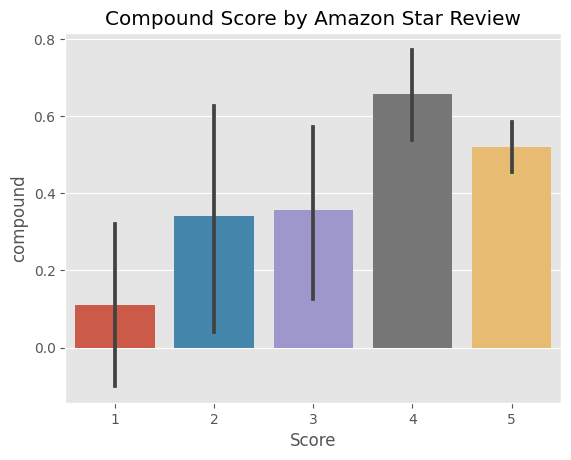

In [ ]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

As assumed, from the above it can be observed that the compound scores are higher for scores that tend to be positive sentiment for a text.

Let's plot the same for all three, negative, neutral and positive sentiments.

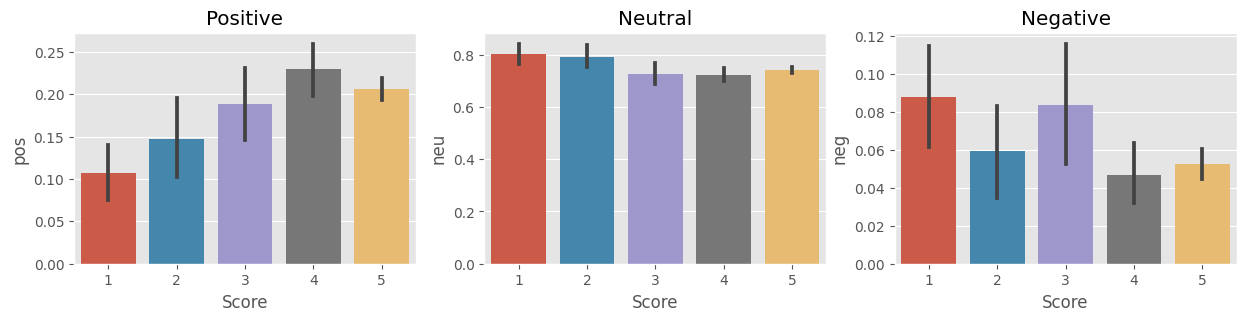

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15,3))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

So far, the model only looked at each word in the sentence/review and scored each individually. This has a limitation. The human language has a lot of importance given to context.

The next model will take context also into consideration.

# **Roberta Pertained Model**

This model is provided by HuggingFace and is trained of a large corpus of data. This transformer model accounts for the words and their context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

We use a specific model that has been pretrained on a lot of data for Sentiment Analysis provided by HuggingFace.

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

When we run the AutoTokenizer and AutoModelForSequenceClassification methods and load it from a pretrained model, it will download the model weights that have been stored. This is called **Transfer Learning**. This model was trained on Twitter data and we are going to use these trained weights, apply it to our dataset and get results.

In [ ]:
# recap of VADER results on our example

print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

Next we will run this on Roberta Model after encoding the text.

In [ ]:
# encoding the text
encoded_text = tokenizer(example, return_tensors = 'pt')

# run for Roberta Model
output = model(**encoded_text)
scores = output[0][0].detach().numpy() # to store as numpy array
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


Clearly, the Roberta Model's value for the negative is much higher than the VADER Model.

We will next run this on the entire dataset.

In [ ]:
# making a function out of the previous codes

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
# running the model on whole data

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['ProductId']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id B003ZFRKGO
Broke for id B000NY8ODS


The try except clause was added to break through whenever a runtime error is occured. This error occurs in this case because the text exceeded the size that could have been handled.

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ProductId'})
results_df = results_df.merge(df, how='left')
results_df.head(3)

,ProductId,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Now we have added the VADER and Roberta results all into the metadata.

# **Comparison of scores between the two models**

In [ ]:
results_df.columns

Index(['ProductId', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

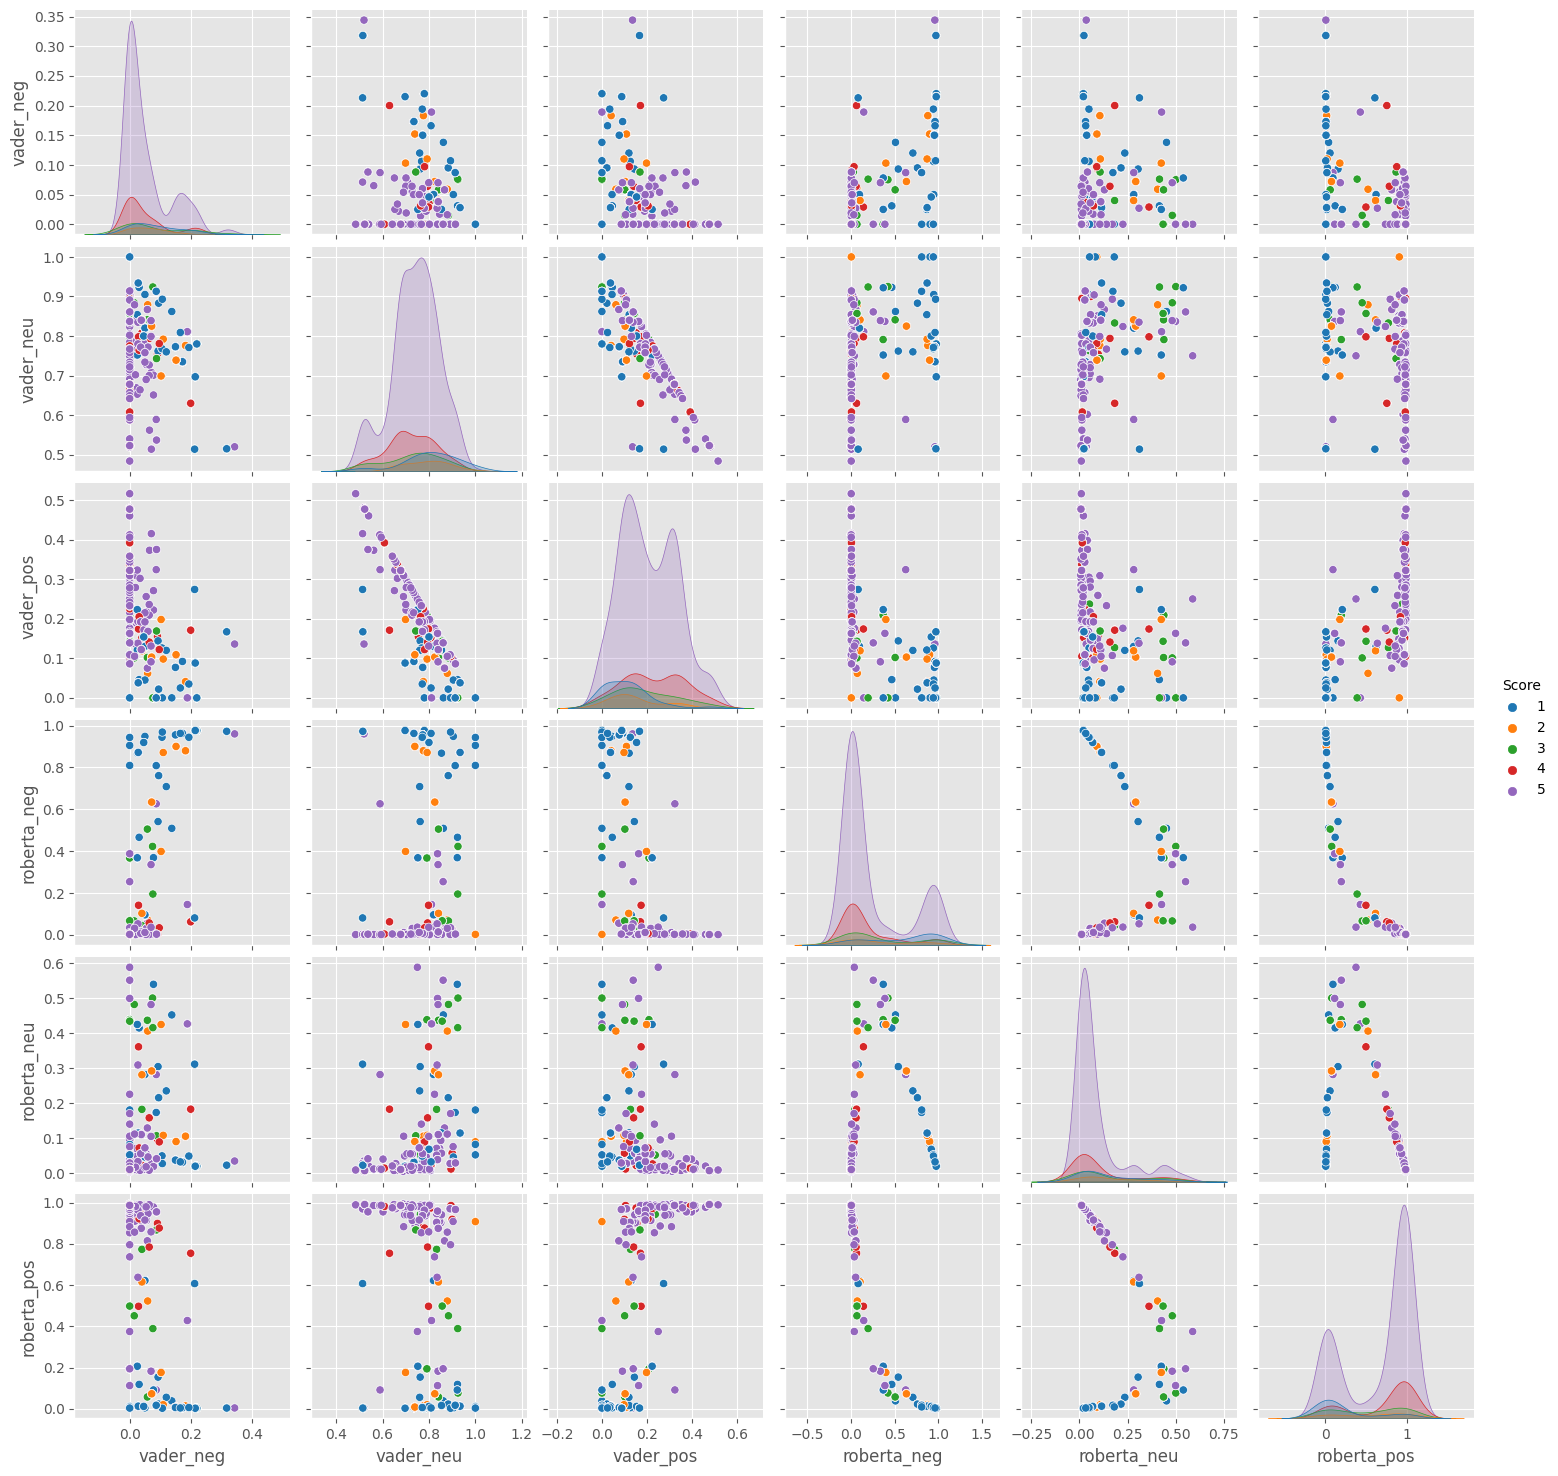

In [ ]:
sns.pairplot(data = results_df, vars = ['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'], hue = 'Score', palette = 'tab10')
plt.show()

From the above graph, it can be concluded that the Roberta Model is more confident than the VADERS Model.

Next, we will look at the cases where the model does the opposite of what it should be doing, i.e. mark negative for 5 star reviews and positive for 1 star reviews.

# **Edge Cases from the results**

**Postive sentiment for 1 star review**

In [ ]:
# Roberta positive

results_df.query('Score == 1') \
      .sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I received the items in a timely manner. Upon receipt, I removed a pack to consume. The pop-tart was STALE and left an awful taste in my mouth.'

One look at the sentence helps us understand that the statement is negative but it starts off on a positive note with words like 'timely manner'. This confused the model.

In [ ]:
# VADER positive

results_df.query('Score == 1') \
      .sort_values('vader_pos', ascending = False)['Text'].values[0]

"I used to buy this sugar for years. I do not eat much sugar, but still. This sugar is called turbinado sugar, but is misleading. I picked this brand just because it says real turbinado sugar, and other brands (in the local food store) that their sugar is brown because it is colored with caramel or something.<br /><br />HOW did i find out? I needed just a sweet water few days ago. I put this Sugar in The Raw in the glass. The water became brown and on the bottom of the glass i got just PURE WHITE SUGAR CRYSTALS!!!!! What a shame on the producer! U can try to put this sugar in your mouth and after few seconds you will spit out pure white crystals as well.<br /><br />I'm just wondering if the consumers can hold the company liable for such a practice."

Similar to the Roberta results, the model got confused because of the positive beginning of the sentence.

**Negative sentiment for 5 star review**

In [ ]:
# Roberta negative

results_df.query('Score == 5') \
      .sort_values('roberta_neg', ascending = False)['Text'].values[0]

"We really like the McCann's steel cut oats but find we don't cook it up too often.<br />This tastes much better to me than the grocery store brands and is just as convenient.<br />Anything that keeps me eating oatmeal regularly is a good thing."

In [ ]:
# VADER negative

results_df.query('Score == 5') \
      .sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

And just like before, the model confused itself by the negative literal sentiment in the text which actually is positive.